In [1]:
import collections as co
import pandas as pd
import numpy as np
import seaborn as sns
import re
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, SequenceFace
from scipy.cluster import hierarchy

In [2]:
def getNewick(node, newick, parentdist, leaf_names):
    
    if node.is_leaf():
        return(leaf_names[node.id] + ":" + np.format_float_positional(parentdist - node.dist) + newick)
        #return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    
    else:
        if len(newick) > 0:
            newick = "):" + np.format_float_positional(parentdist - node.dist) + newick
            #newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), "," + newick, node.dist, leaf_names)
        #newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        
        newick = "(" + newick
        #newick = "(%s" % (newick)
        return(newick)

In [102]:
def getTree(framelink, frameclust, framemeta, segment = 4, prune = True):
    
    treequery = frameclust.loc[4].join(framemeta)[['cluster', 'host', 'year', 'protein', 'subtype']]
    treedict = treequery.to_dict()
    treelabel = treequery.index.values
    treestyle = TreeStyle()
    treelink = framelink.loc[4].drop(columns=['parent']).to_numpy()
    treehierarchy = hierarchy.to_tree(treelink, False)
    treenewick = getNewick(treehierarchy, "", treehierarchy.dist, treelabel)
    
    tree = Tree(treenewick)
    listcluster = list(set(treedict['cluster'].values()))
    prunecluster = []
    
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"
        node.img_style['bgcolor'] = 'lightgrey'
    
    for leaf in tree.iter_leaves():
        leaf.host = treedict['host'].get(leaf.name, "none")
        leaf.year = treedict['year'].get(leaf.name, "none")
        leaf.cluster = treedict['cluster'].get(leaf.name, "none")
        leaf.protein = treedict['protein'].get(leaf.name, "none")
        leaf.subtype = treedict['subtype'].get(leaf.name, "none")
    
    if -1 in listcluster:
        listcluster.remove(-1)
    
    for cluster in listcluster:
        listmember = tree.search_nodes(cluster=cluster)
        nodecluster = tree.get_common_ancestor(listmember)
        nodecluster.name = f'cluster {cluster}'
        nodecluster.size = len(listmember)
        nodecluster.host = co.Counter([member.host for member in listmember]).most_common(1)[0][0]
        
        nodecluster.add_face(AttrFace("name", fsize=10), 0, position="aligned")
        nodecluster.add_face(AttrFace("size", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned") 
        
        #---------- direkt hier nach unten coloren (alle children plus cluster node coloren) ----------
        #---------- maybe danach durch monophyletic nach oben coloren falls wirklich notwendig --------
        
        prunecluster.append(nodecluster.name)
        
    if prune == True:
        tree.prune(prunecluster)
        
    return(tree)

In [89]:
link = pd.read_csv('linkage.csv', sep = ',', na_filter = False, header = 0)
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
framelink = link.set_index(keys = 'segment')
frameclust = cluster.reset_index().set_index(keys = ['segment', 'accession']).drop(labels = ['H', 'N'], axis = 1)

In [90]:
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
framemeta = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
framemeta.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation']
framemeta[['month', 'day', 'year']] = framemeta['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
framemeta.set_index(keys = 'accession', inplace = True)

In [103]:
tree = getTree(framelink, frameclust, framemeta, 4, True)

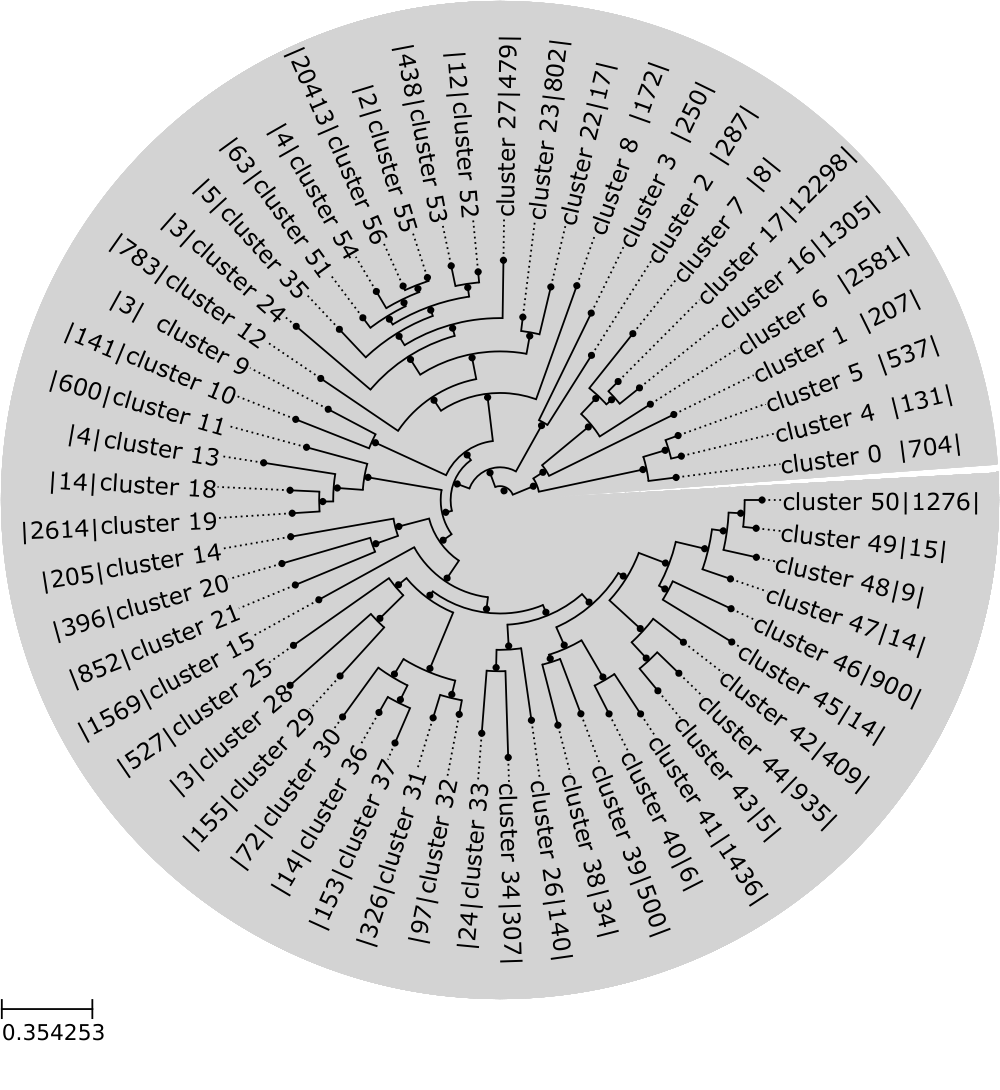

In [104]:
treestyle =  TreeStyle()
treestyle.show_leaf_name = False
treestyle.draw_guiding_lines = True
treestyle.guiding_lines_color = 'black'
treestyle.mode = "c"
tree.render(file_name = '%%inline', tree_style = treestyle, w=1000)